# Market Basket Analysis and Customer Segmentation

Jungseo Lee (jungseo@umich.edu)

Data Science can play a crucial role in marketing by leveraging analytical and statistical skills to extract meaningful insights from data. Through this project, I aim to uncover intriguing insights into customer groups and purchase behavior, which will be instrumental in shaping future marketing campaigns and increasing sales using Instacart's order data.

In this project, my focus will be on:

1. Conducting exploratory analysis to identify interesting customer purchasing behavior, including frequently purchased items and order times.
2. Utilizing basket analysis techniques to discover interesting combinations of items.
3. Developing a customer segmentation model based on customers' purchasing behavior.

The goal is to derive actionable insights that will inform strategic decision-making, enhance marketing strategies, and contribute to the overall success of Instacart's sales initiatives.

### Data

The data is from the previous Kaggle competition hosted by Instacart. All data files are available in a separate 'data' directory.
You can find data dictionary via the [link](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

In [1]:
# import needed packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpmax, fpgrowth
import warnings
# Filter out all warnings
warnings.filterwarnings("ignore")

## 1. Import Data

In [2]:
orders = pd.read_csv("data/orders.csv")
order_products = pd.read_csv("data/order_products__prior.csv")
products = pd.read_csv("data/products.csv")
departments = pd.read_csv("data/departments.csv")
aisles = pd.read_csv("data/aisles.csv")

## 2. Exploratory Data Analysis (EDA)

In [3]:
orders.shape

(3421083, 7)

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products.shape

(32434489, 4)

In [6]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.shape

(49688, 4)

In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments.shape

(21, 2)

In [10]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
aisles.shape

(134, 2)

In [12]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### 1) Customer purchasing behavior: frequent purchasing items, frequent order time

To derive insights into frequently purchased items and ordered times, it is necessary to merge three distinct data frames: orders, order_products, and products.

In [13]:
ordered_products = pd.merge(orders, order_products, how='outer', on='order_id')

In [14]:
ordered_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0


In [15]:
ordered_products.shape

(32640698, 10)

In [16]:
ordered_products = pd.merge(ordered_products, products, how='left', on='product_id')

In [17]:
ordered_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0


In [18]:
ordered_products.shape

(32640698, 13)

In [19]:
ordered_products = pd.merge(ordered_products, departments, how='left', on='department_id')

In [20]:
ordered_products.shape

(32640698, 14)

In [21]:
# leave only needed columns
frequently_purchased = ordered_products[['order_id','user_id','order_hour_of_day','product_id','product_name', 'department']]

In [22]:
frequently_purchased.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department
0,2539329,1,8,196.0,Soda,beverages
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,8,12427.0,Original Beef Jerky,snacks
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household


In [23]:
# count the orders by the order_hour_of_day
order_time = frequently_purchased.groupby('order_hour_of_day')['order_id'].count()

In [24]:
order_time.to_frame()

,order_id
order_hour_of_day,
0,220334
1,116588
2,69903
3,51675
4,53635
5,88659
6,292532
7,897149
8,1729853


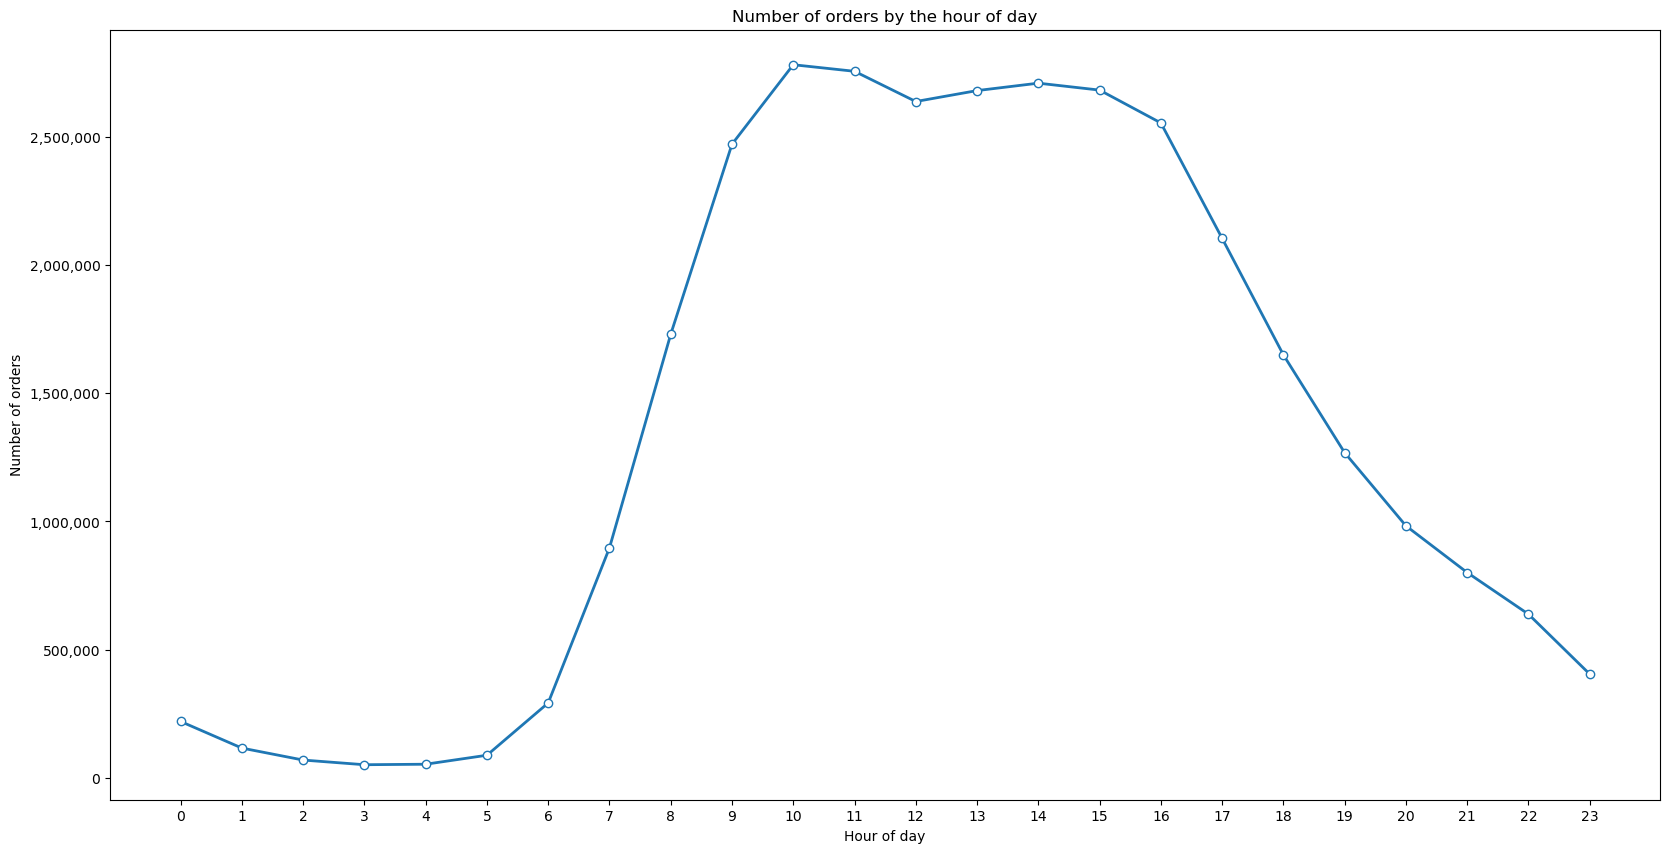

In [25]:
ax = order_time.plot(lw=2, title='Number of orders by the hour of day', marker='o', markerfacecolor='white')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Number of orders')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

In [26]:
# Distribution of number of products per one order
num_product = frequently_purchased.groupby('order_id')['product_id'].count()

In [27]:
num_product.to_frame()

,product_id
order_id,
1,0
2,9
3,8
4,13
5,26
...,...
3421079,1
3421080,9
3421081,7


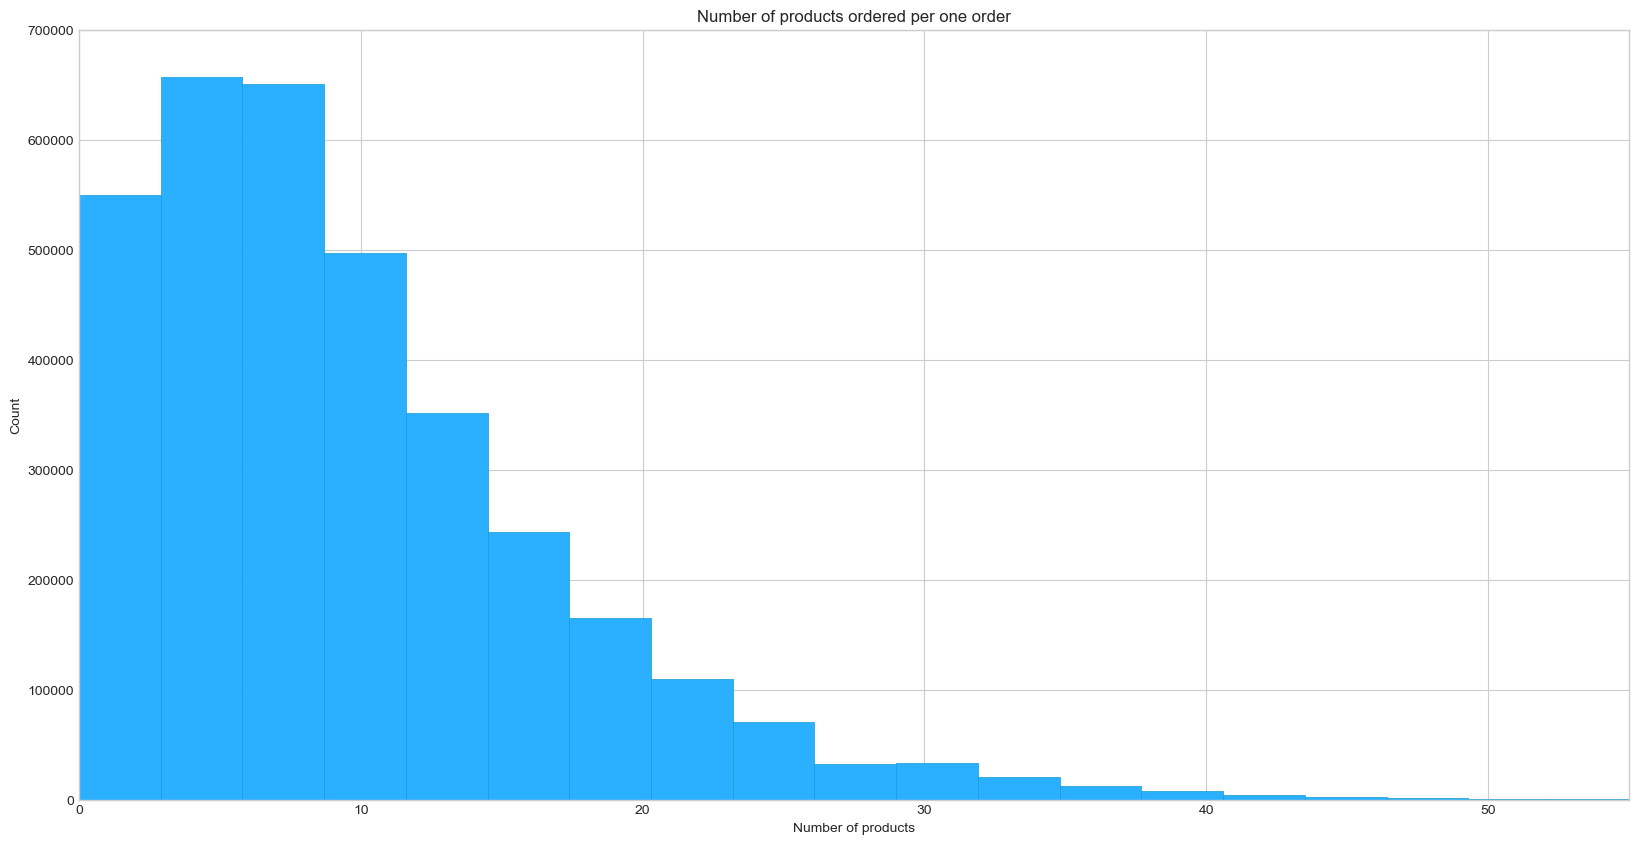

In [28]:
plt.style.use('seaborn-whitegrid')

plt.hist(num_product, bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.axis([0, 55, 0, 700000])
plt.title('Number of products ordered per one order') 
plt.xlabel('Number of products') 
plt.ylabel('Count') 
plt.show()

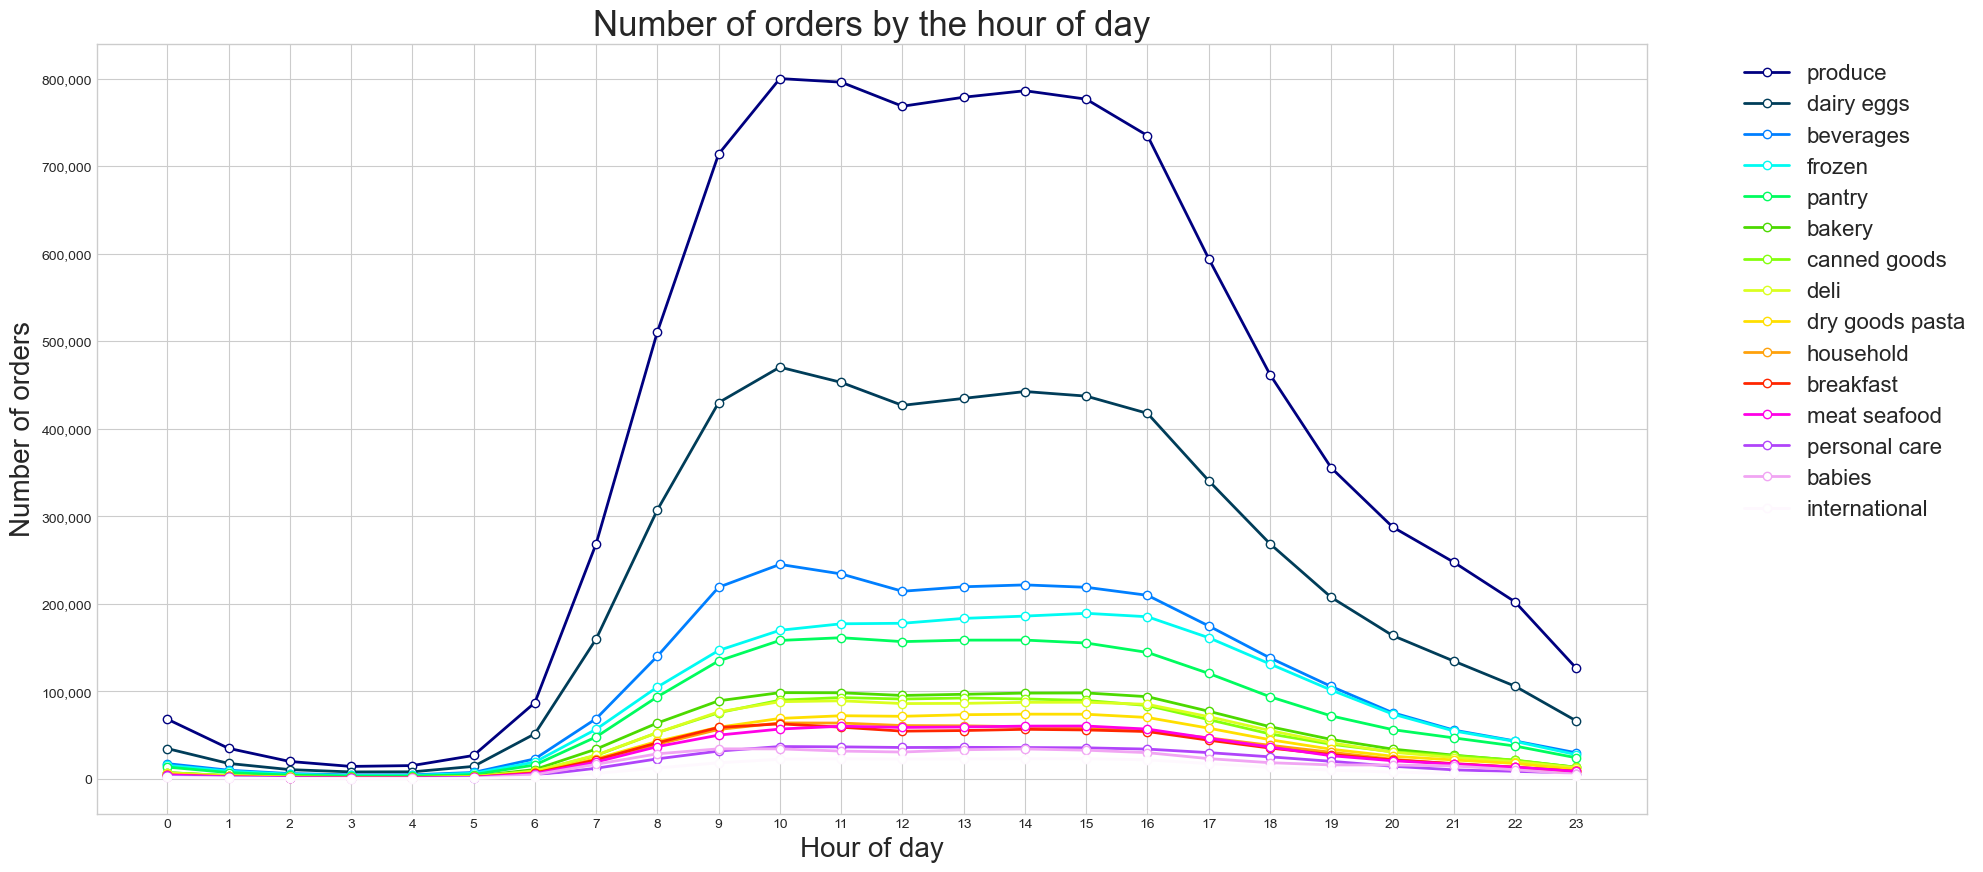

In [29]:
# Number of orders per each hour by each department
num_order_department = pd.pivot_table(frequently_purchased, index='order_hour_of_day', columns='department', values='order_id', aggfunc='count')
num_order_department.loc['total'] = num_order_department.iloc[:, :-1].sum()
num_order_department = num_order_department.transpose().sort_values(by=['total'], ascending=False).iloc[:15].transpose().iloc[:-1]
ax = num_order_department.plot(lw=2, marker='o', markerfacecolor='white')
ax.set_title('Number of orders by the hour of day', fontsize=25)
ax.set_xlabel('Hour of day', fontsize=20)
ax.set_ylabel('Number of orders', fontsize=20)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1, len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=16)

Based on the analysis above, I have found orders are mainly made between the day time (9 am to 4 pm). Most orders are made with 2-8 products per order. "Product, dairy eggs, beverages, frozen, pantry" are the top 5 departments that were ordered the most. You can find more details in the plots above.

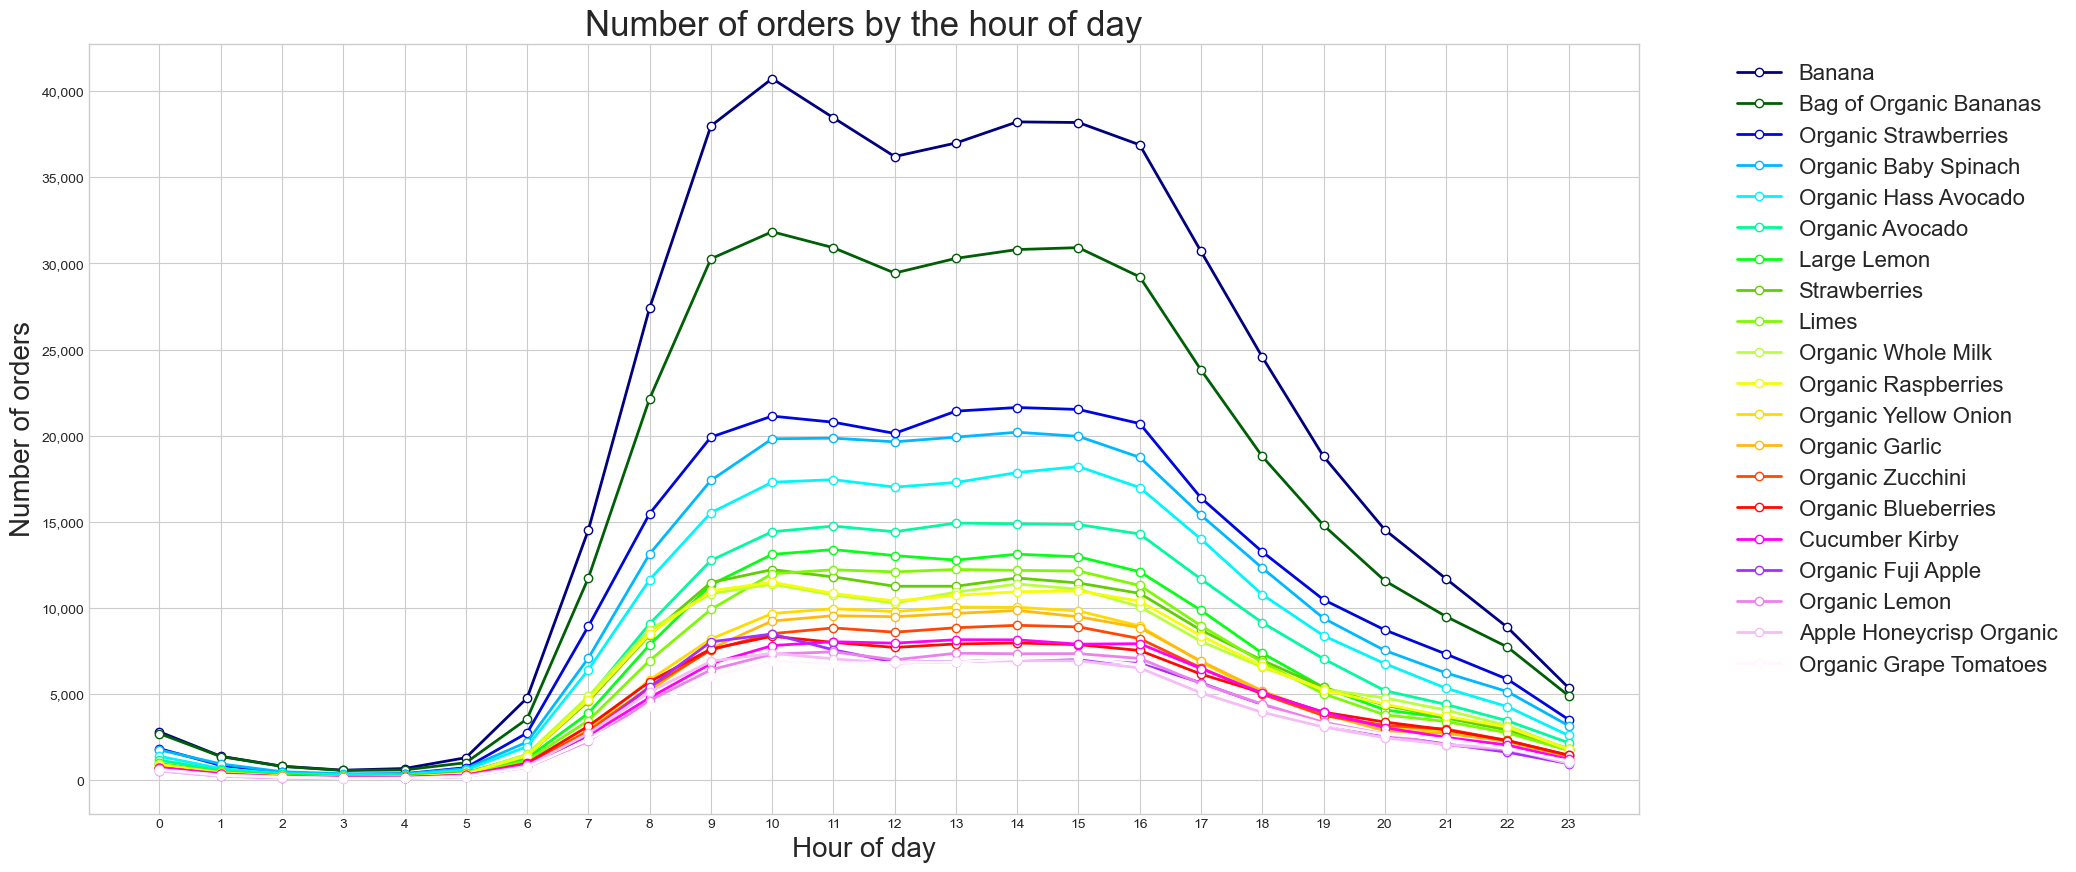

In [30]:
# Finding frequently purchased products
num_order_product = pd.pivot_table(frequently_purchased, index='order_hour_of_day', columns='product_name', values='order_id', aggfunc='count')
num_order_product.loc['total'] = num_order_product.iloc[:, :-1].sum()
num_order_product = num_order_product.transpose().sort_values(by=['total'], ascending=False).iloc[:20].transpose().iloc[:-1]
ax = num_order_product.plot(lw=2, marker='o', markerfacecolor='white')
ax.set_title('Number of orders by the hour of day', fontsize=25)
ax.set_xlabel('Hour of day', fontsize=20)
ax.set_ylabel('Number of orders', fontsize=20)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1, len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=16)

"Banana, Bag of Organic Bananas, Organic Strawberries, Organic Baby Spinach, Organic Hass Avoado" are the top 5 products that ordered the most.

### 2) Number of unique products, departments, users in the order data

In [31]:
frequently_purchased.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department
0,2539329,1,8,196.0,Soda,beverages
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,8,12427.0,Original Beef Jerky,snacks
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household


In [32]:
frequently_purchased.shape

(32640698, 6)

In [33]:
# number of unique products
frequently_purchased.product_id.nunique()

49677

In [34]:
# number of unique departments
frequently_purchased.department.nunique()

21

In [35]:
# number of unique users
frequently_purchased.user_id.nunique()

206209

## 3. Basket Analysis

I would like to find the interesting combinations of the products through the basket analysis.

In [36]:
df = frequently_purchased

In [37]:
# Dealing with missing values
df.isna().sum()

order_id                  0
user_id                   0
order_hour_of_day         0
product_id           206209
product_name         206209
department           206209
dtype: int64

In [38]:
## As import infomrmation got missing, I will just drop the NaN values
df = df.dropna()

In [39]:
df.isna().sum()

order_id             0
user_id              0
order_hour_of_day    0
product_id           0
product_name         0
department           0
dtype: int64

In [40]:
df.shape

(32434489, 6)

In [41]:
# Change datatype of each column
convert_dict = {'order_id':int,
                'user_id':int,
                'order_hour_of_day':int,
                'product_id':int,
                'product_name':str,
                'department':str}
df = df.astype(convert_dict)
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department
0,2539329,1,8,196,Soda,beverages
1,2539329,1,8,14084,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,8,12427,Original Beef Jerky,snacks
3,2539329,1,8,26088,Aged White Cheddar Popcorn,snacks
4,2539329,1,8,26405,XL Pick-A-Size Paper Towel Rolls,household


### 1) Preparing the data for the Apriori Algorithm


Based on the hour of day, I would like to divide the order data into 3 different data categories: morning, daytime, evening.

Time Categorization:

* Morning: 0 to 7
* Daytime: 8 to 16
* Evening: 17 to 23

In [42]:
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department
0,2539329,1,8,196,Soda,beverages
1,2539329,1,8,14084,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,8,12427,Original Beef Jerky,snacks
3,2539329,1,8,26088,Aged White Cheddar Popcorn,snacks
4,2539329,1,8,26405,XL Pick-A-Size Paper Towel Rolls,household


In [43]:
df_morning = df[(df.order_hour_of_day <= 7) & (df.order_hour_of_day >= 0)]
df_daytime = df[(df.order_hour_of_day <= 16) & (df.order_hour_of_day >= 8)]
df_evening = df[(df.order_hour_of_day <= 23) & (df.order_hour_of_day >= 17)]

In [44]:
# concatenate product_ids in one column based on the order_id
morning_product_sets = df_morning.groupby(['order_id'])['product_name'].transform(lambda x : ', '.join(x))
daytime_product_sets = df_daytime.groupby(['order_id'])['product_name'].transform(lambda x : ', '.join(x))
evening_product_sets = df_evening.groupby(['order_id'])['product_name'].transform(lambda x : ', '.join(x))

In [45]:
# drop duplicates 
morning_product_sets = morning_product_sets.drop_duplicates()
daytime_product_sets = daytime_product_sets.drop_duplicates()
evening_product_sets = evening_product_sets.drop_duplicates()

In [46]:
morning_product_sets = pd.DataFrame(morning_product_sets)
daytime_product_sets = pd.DataFrame(daytime_product_sets)
evening_product_sets = pd.DataFrame(evening_product_sets)

In [47]:
# save data in csv format
morning_product_sets.to_csv('data/morning_product.csv')
daytime_product_sets.to_csv('data/daytime_product.csv')
evening_product_sets.to_csv('data/evening_product.csv')

# If you need to import data from files
morning_product_sets = pd.read_csv('data/morning_product.csv')
morning_product_sets.drop('Unnamed: 0',axis=1, inplace=True)
daytime_product_sets = pd.read_csv('data/daytime_product.csv')
daytime_product_sets.drop('Unnamed: 0',axis=1, inplace=True)
evening_product_sets = pd.read_csv('data/evening_product.csv')
evening_product_sets.drop('Unnamed: 0',axis=1, inplace=True)

In [48]:
morning_product_sets['unique_product'] = [set(i) for i in morning_product_sets.product_name.str.split(", ")]
daytime_product_sets['unique_product'] = [set(i) for i in daytime_product_sets.product_name.str.split(", ")]
evening_product_sets['unique_product'] = [set(i) for i in evening_product_sets.product_name.str.split(", ")]

In [49]:
# import needed packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [50]:
morning_product_sets.head()

,product_name,unique_product
0,"Soda, Pistachios, Original Beef Jerky, Bag of ...","{Bag of Organic Bananas, Original Beef Jerky, ..."
1,"Soda, Original Beef Jerky, Pistachios, Organic...","{XL Pick-A-Size Paper Towel Rolls, Original Be..."
2,"Soda, Original Beef Jerky, Pistachios, Organic...","{Soda, Pistachios, Original Beef Jerky, Organi..."
3,"Organic Low Fat Chocolate Milk, Organic Jasmin...","{Original No Pulp 100% Florida Orange Juice, L..."
4,"Organic Baby Spinach, Michigan Organic Kale, B...","{Organic Thyme, Italian (Flat), Organic Dried ..."


In [51]:
morning_product_sets.iloc[0]['product_name']

'Soda, Pistachios, Original Beef Jerky, Bag of Organic Bananas, Aged White Cheddar Popcorn, Cinnamon Toast Crunch'

In [52]:
morning_product_sets.iloc[0]['unique_product']

{'Aged White Cheddar Popcorn',
 'Bag of Organic Bananas',
 'Cinnamon Toast Crunch',
 'Original Beef Jerky',
 'Pistachios',
 'Soda'}

Detailed that should be decided:

    1. Minimum support value
    2. How many itemsets

The initial objective of the project was to identify prevalent combinations of product purchases. Accordingly, it is essential to explore popular 2-item sets frequently bought together. This analytical process holds strategic significance, particularly if the company aims to develop a recommnedation algorithm for a "frequently bought together" feature. Such an algorithm could be implemented to provide product recommendations to customers when they add items to their cart.

Prior to executing the aforementioned function designed to extract frequent k-item sets, it is essential to comprehend the role of each parameter. The parameter 'k' serves as a determinant for the number of item sets to be identified. For instance, setting 'k' to 3 implies a desire to identify all 3-item sets (combinations of 3 distinct products) that occur more frequently than a specified fraction denoted by 'min_support'.

The 'min_support' parameter represents the fraction of transactions that include all the items within the item set. When 'min_support' is set to 0.05, it signifies that the fraction of transactions exhibiting the probability of items occurring together, in comparison to the total number of transactions, is 5 out of 100.

In [53]:
morning_product_sets.shape

(167758, 2)

Due to the large volume of raw data, I had to randomly sample 10,000 rows from each category.

In [54]:
df_morning = morning_product_sets.sample(n=10000)
df_daytime = daytime_product_sets.sample(n=10000)
df_evening = evening_product_sets.sample(n=10000)

In [55]:
df_morning.shape

(10000, 2)

In [56]:
## Making database based on the mlb funciton
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
morning_matrix = pd.DataFrame(mlb.fit_transform(df_morning['unique_product']), columns=mlb.classes_)   # transform dataframe to a matrix where each row represents an itemset and each column represents an item
morning_database = mlb.inverse_transform(mlb.fit_transform(df_morning['unique_product']))

In [57]:
morning_matrix

,Apricot & Banana Stage 2 Baby Food,Instant,#2 Coffee Filters,#2 Mechanical Pencils,#4 Natural Brown Coffee Filters,& Baby Wipes,& Blueberry with Quinoa Organic Baby Food,& Cheese Biscuit,& Cheese English Muffin,& Cheese Sandwiches,...,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Orange Pulp!,with Pulp,with Sea Salt,with Seasoned Roasted Potatoes Scrambled Eggs & Sausage,with Spinach,with Tofu,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
mlb = MultiLabelBinarizer()
daytime_matrix = pd.DataFrame(mlb.fit_transform(df_daytime['unique_product']), columns=mlb.classes_)   # transform dataframe to a matrix where each row represents an itemset and each column represents an item
daytime_database = mlb.inverse_transform(mlb.fit_transform(df_daytime['unique_product']))

In [59]:
mlb = MultiLabelBinarizer()
evening_matrix = pd.DataFrame(mlb.fit_transform(df_evening['unique_product']), columns=mlb.classes_)   # transform dataframe to a matrix where each row represents an itemset and each column represents an item
evening_database = mlb.inverse_transform(mlb.fit_transform(df_evening['unique_product']))

### 2) Applying the Apriori Algorithm

In this project, the Apriori Algorithm will be utilized. This algorithm is widely employed for discovering interesting relationships, patterns, or associations among a set of items in datasets. Specifically, the Apriori algorithm is widely used for mining frequent itemsets and generating association rules.

In [60]:
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.preprocessing import TransactionEncoder


def frequent_itemsets (database, min_support=0.005):
    te = TransactionEncoder()
    te_ary = te.fit(database).transform(database)      
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    return frequent_itemsets

In [61]:
morning_fi = frequent_itemsets(morning_database)
daytime_fi = frequent_itemsets(daytime_database)
evening_fi = frequent_itemsets(evening_database)

In [62]:
morning_fi

,support,itemsets
0,0.0093,(Organic Green Seedless Grapes)
1,0.1621,(Banana)
2,0.0984,(Organic Strawberries)
3,0.0191,(Extra Virgin Olive Oil)
4,0.0086,(Organic Yellow Peaches)
...,...,...
415,0.0054,"(Organic Strawberries, Organic Kiwi)"
416,0.0051,"(Bag of Organic Bananas, Organic Kiwi)"
417,0.0089,"(YoKids Squeezers Organic Low-Fat Yogurt, Stra..."
418,0.0089,"(Organic Red Radish, Bunch)"


In [63]:
daytime_fi

,support,itemsets
0,0.0219,(Organic Small Bunch Celery)
1,0.0214,(Fresh Cauliflower)
2,0.1470,(Banana)
3,0.0819,(Organic Strawberries)
4,0.0308,(Organic Lemon)
...,...,...
394,0.0057,"(Milk, Organic, Vitamin D)"
395,0.0056,"(Organic D'Anjou Pears, Bag of Organic Bananas)"
396,0.0050,"(Red Vine Tomato, Banana)"
397,0.0050,"(Bibb) Lettuce, Butter)"


In [64]:
evening_fi

,support,itemsets
0,0.1136,(Bag of Organic Bananas)
1,0.0544,(Organic Avocado)
2,0.0334,(Organic Garlic)
3,0.0231,(Organic Cilantro)
4,0.0162,(Bunch)
...,...,...
366,0.0073,"(Organic, Vitamin D)"
367,0.0073,"(Milk, Organic, Vitamin D)"
368,0.0067,"(Bag of Organic Bananas, Organic Tomato Cluster)"
369,0.0050,"(Organic Hass Avocado, Organic Tomato Cluster)"


As observed above, distinctions emerge in frequent itemsets based on the timing of order placement. We have identified close to 400 itemsets with support exceeding 0.005 (0.5%) per category. Subsequently, the focus shifts to uncovering compelling combinations of items within these frequent itemsets.

### 3) Find out the interesting combinations

To decide which metric to use to evaluate the association rules and select the thresholds, please find the information below.
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

* Support: Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database. We refer to an itemset as a "frequent itemset" if your support larger than a specified minimum-support threshold. [0,1]

            - 'antecedent support': the proportion of transactions that contain the antecedent
            - 'consequent support': the proportion of transactions that contain the consequent
            - 'support': the proportion of transactions that contain the combined itemset (antecedents or consequents)
            
* Confidence: The probability of seeing the consequent in a transaction given that it also contains the antecedent. (maximal: 1) [0, 1]

* Lift: Commonly used to measure how much more often the antecedent and consequent occur together than we would expect if they were statistically independent. (If antecedent and consequent are independent, the Lift score will be exactly 1.) [0, inf]

* Leverage: The difference between the observed frequency of antecedent and consequent appearing together and the frequency that would be expected if antecedent and consequent were independent. (0 indicates independence.) [-1, 1]

* Conviction: high conviction value means that the consequent is highly depending on the antecedent. [0, inf]

In [65]:
morning_ar_matrix = association_rules(morning_fi, metric='lift', min_threshold=5)
morning_ar_matrix 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Clementines),(Bag),0.0259,0.0168,0.0153,0.590734,35.162714,0.014865,2.402347
1,(Bag),(Clementines),0.0168,0.0259,0.0153,0.910714,35.162714,0.014865,10.909920
2,(Milk),(Organic),0.0145,0.0246,0.0096,0.662069,26.913373,0.009243,2.886388
3,(Organic),(Milk),0.0246,0.0145,0.0096,0.390244,26.913373,0.009243,1.616220
4,(Milk),(Vitamin D),0.0145,0.0106,0.0104,0.717241,67.664281,0.010246,3.499098
5,(Vitamin D),(Milk),0.0106,0.0145,0.0104,0.981132,67.664281,0.010246,52.231500
6,(Organic),(Vitamin D),0.0246,0.0106,0.0088,0.357724,33.747507,0.008539,1.540458
7,(Vitamin D),(Organic),0.0106,0.0246,0.0088,0.830189,33.747507,0.008539,5.744022
8,"(Milk, Organic)",(Vitamin D),0.0096,0.0106,0.0088,0.916667,86.477987,0.008698,11.872800
9,"(Milk, Vitamin D)",(Organic),0.0104,0.0246,0.0088,0.846154,34.396498,0.008544,6.340100


In [66]:
daytime_ar_matrix = association_rules(daytime_fi, metric='lift', min_threshold=5)
daytime_ar_matrix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Garlic),(Organic Yellow Onion),0.0380,0.0424,0.0083,0.218421,5.151440,0.006689,1.225212
1,(Organic Yellow Onion),(Organic Garlic),0.0424,0.0380,0.0083,0.195755,5.151440,0.006689,1.196152
2,(Organic Red Radish),(Bunch),0.0094,0.0150,0.0094,1.000000,66.666667,0.009259,inf
3,(Bunch),(Organic Red Radish),0.0150,0.0094,0.0094,0.626667,66.666667,0.009259,2.653393
4,(Clementines),(Bag),0.0248,0.0170,0.0151,0.608871,35.815939,0.014678,2.513237
5,(Bag),(Clementines),0.0170,0.0248,0.0151,0.888235,35.815939,0.014678,8.725474
6,(Milk),(Organic),0.0126,0.0217,0.0065,0.515873,23.772950,0.006227,2.020751
7,(Organic),(Milk),0.0217,0.0126,0.0065,0.299539,23.772950,0.006227,1.409643
8,(Milk),(Vitamin D),0.0126,0.0087,0.0086,0.682540,78.452837,0.008490,3.122595
9,(Vitamin D),(Milk),0.0087,0.0126,0.0086,0.988506,78.452837,0.008490,85.903800


In [67]:
evening_ar_matrix = association_rules(evening_fi, metric='lift', min_threshold=5)
evening_ar_matrix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Cilantro),(Limes),0.0231,0.0424,0.0057,0.246753,5.819652,0.004721,1.271297
1,(Limes),(Organic Cilantro),0.0424,0.0231,0.0057,0.134434,5.819652,0.004721,1.128626
2,(Organic Red Radish),(Bunch),0.0093,0.0162,0.0093,1.000000,61.728395,0.009149,inf
3,(Bunch),(Organic Red Radish),0.0162,0.0093,0.0093,0.574074,61.728395,0.009149,2.325991
4,(Clementines),(Bag),0.0156,0.0131,0.0106,0.679487,51.869250,0.010396,3.079128
5,(Bag),(Clementines),0.0131,0.0156,0.0106,0.809160,51.869250,0.010396,5.158256
6,(YoKids Squeezers Organic Low-Fat Yogurt),(Strawberry),0.0060,0.0111,0.0060,1.000000,90.090090,0.005933,inf
7,(Strawberry),(YoKids Squeezers Organic Low-Fat Yogurt),0.0111,0.0060,0.0060,0.540541,90.090090,0.005933,2.163412
8,(Organic Garlic),(Organic Yellow Onion),0.0334,0.0314,0.0065,0.194611,6.197795,0.005451,1.202648
9,(Organic Yellow Onion),(Organic Garlic),0.0314,0.0334,0.0065,0.207006,6.197795,0.005451,1.218925


I would like to add mutual information column with calculating mutual information uses the three support values 1) antecedent support 2) consequent support and 3) support to measure of dependence between two variables.

Mutual information is a measure of the amount of information that knowing the value of one variable provides about another variable. In other words, it quantifies the degree of dependence between two variables.

In [68]:
# add mutual information
def mi(antecedent_support, consequent_support, support):

    mutual_information = 0
    # (x=1, y=1)
    mi1 = support * np.log2(support/(antecedent_support*consequent_support))
    mutual_information += mi1
    
    # (x=1, y=0)
    mi2 = (antecedent_support-support) * np.log2((antecedent_support-support)/(antecedent_support*(1-consequent_support)))
    mutual_information += mi2
    
    # (x=0, y=1)
    mi3 = (consequent_support-support) * np.log2 ((consequent_support-support)/((1-antecedent_support)*(consequent_support)))
    mutual_information += mi3
    
    # (x=0, y=0)
    mi4 = (1 + support - antecedent_support - consequent_support) * np.log2((1 + support - antecedent_support - consequent_support)/((1-antecedent_support)*(1-consequent_support)))
    mutual_information += mi4
    
    return mutual_information

def add_mi_info(x):
    antecedent_support = x['antecedent support']
    consequent_support = x['consequent support']
    support = x['support']
    return mi(antecedent_support, consequent_support, support)

In [69]:
morning_ar_matrix['mutual information'] = morning_ar_matrix.apply(lambda x:add_mi_info(x), axis=1)
morning_ar_matrix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
0,(Clementines),(Bag),0.0259,0.0168,0.0153,0.590734,35.162714,0.014865,2.402347,0.081617
1,(Bag),(Clementines),0.0168,0.0259,0.0153,0.910714,35.162714,0.014865,10.909920,0.081617
2,(Milk),(Organic),0.0145,0.0246,0.0096,0.662069,26.913373,0.009243,2.886388,0.041119
3,(Organic),(Milk),0.0246,0.0145,0.0096,0.390244,26.913373,0.009243,1.616220,0.041119
4,(Milk),(Vitamin D),0.0145,0.0106,0.0104,0.717241,67.664281,0.010246,3.499098,0.069545
5,(Vitamin D),(Milk),0.0106,0.0145,0.0104,0.981132,67.664281,0.010246,52.231500,0.069545
6,(Organic),(Vitamin D),0.0246,0.0106,0.0088,0.357724,33.747507,0.008539,1.540458,0.042660
7,(Vitamin D),(Organic),0.0106,0.0246,0.0088,0.830189,33.747507,0.008539,5.744022,0.042660
8,"(Milk, Organic)",(Vitamin D),0.0096,0.0106,0.0088,0.916667,86.477987,0.008698,11.872800,0.061791
9,"(Milk, Vitamin D)",(Organic),0.0104,0.0246,0.0088,0.846154,34.396498,0.008544,6.340100,0.043181


In [70]:
daytime_ar_matrix['mutual information'] = daytime_ar_matrix.apply(lambda x:add_mi_info(x), axis=1)
daytime_ar_matrix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
0,(Organic Garlic),(Organic Yellow Onion),0.0380,0.0424,0.0083,0.218421,5.151440,0.006689,1.225212,0.011800
1,(Organic Yellow Onion),(Organic Garlic),0.0424,0.0380,0.0083,0.195755,5.151440,0.006689,1.196152,0.011800
2,(Organic Red Radish),(Bunch),0.0094,0.0150,0.0094,1.000000,66.666667,0.009259,inf,NaN
3,(Bunch),(Organic Red Radish),0.0150,0.0094,0.0094,0.626667,66.666667,0.009259,2.653393,NaN
4,(Clementines),(Bag),0.0248,0.0170,0.0151,0.608871,35.815939,0.014678,2.513237,0.080457
5,(Bag),(Clementines),0.0170,0.0248,0.0151,0.888235,35.815939,0.014678,8.725474,0.080457
6,(Milk),(Organic),0.0126,0.0217,0.0065,0.515873,23.772950,0.006227,2.020751,0.025005
7,(Organic),(Milk),0.0217,0.0126,0.0065,0.299539,23.772950,0.006227,1.409643,0.025005
8,(Milk),(Vitamin D),0.0126,0.0087,0.0086,0.682540,78.452837,0.008490,3.122595,0.059215
9,(Vitamin D),(Milk),0.0087,0.0126,0.0086,0.988506,78.452837,0.008490,85.903800,0.059215


In [71]:
evening_ar_matrix['mutual information'] = evening_ar_matrix.apply(lambda x:add_mi_info(x), axis=1)
evening_ar_matrix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
0,(Organic Cilantro),(Limes),0.0231,0.0424,0.0057,0.246753,5.819652,0.004721,1.271297,0.008879
1,(Limes),(Organic Cilantro),0.0424,0.0231,0.0057,0.134434,5.819652,0.004721,1.128626,0.008879
2,(Organic Red Radish),(Bunch),0.0093,0.0162,0.0093,1.000000,61.728395,0.009149,inf,NaN
3,(Bunch),(Organic Red Radish),0.0162,0.0093,0.0093,0.574074,61.728395,0.009149,2.325991,NaN
4,(Clementines),(Bag),0.0156,0.0131,0.0106,0.679487,51.869250,0.010396,3.079128,0.061434
5,(Bag),(Clementines),0.0131,0.0156,0.0106,0.809160,51.869250,0.010396,5.158256,0.061434
6,(YoKids Squeezers Organic Low-Fat Yogurt),(Strawberry),0.0060,0.0111,0.0060,1.000000,90.090090,0.005933,inf,NaN
7,(Strawberry),(YoKids Squeezers Organic Low-Fat Yogurt),0.0111,0.0060,0.0060,0.540541,90.090090,0.005933,2.163412,NaN
8,(Organic Garlic),(Organic Yellow Onion),0.0334,0.0314,0.0065,0.194611,6.197795,0.005451,1.202648,0.010721
9,(Organic Yellow Onion),(Organic Garlic),0.0314,0.0334,0.0065,0.207006,6.197795,0.005451,1.218925,0.010721


In [72]:
morning_ar_matrix[morning_ar_matrix['mutual information'] > 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
0,(Clementines),(Bag),0.0259,0.0168,0.0153,0.590734,35.162714,0.014865,2.402347,0.081617
1,(Bag),(Clementines),0.0168,0.0259,0.0153,0.910714,35.162714,0.014865,10.909920,0.081617
4,(Milk),(Vitamin D),0.0145,0.0106,0.0104,0.717241,67.664281,0.010246,3.499098,0.069545
5,(Vitamin D),(Milk),0.0106,0.0145,0.0104,0.981132,67.664281,0.010246,52.231500,0.069545
8,"(Milk, Organic)",(Vitamin D),0.0096,0.0106,0.0088,0.916667,86.477987,0.008698,11.872800,0.061791
13,(Vitamin D),"(Milk, Organic)",0.0106,0.0096,0.0088,0.830189,86.477987,0.008698,5.832356,0.061791


In [73]:
daytime_ar_matrix[daytime_ar_matrix['mutual information'] > 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
4,(Clementines),(Bag),0.0248,0.0170,0.0151,0.608871,35.815939,0.014678,2.513237,0.080457
5,(Bag),(Clementines),0.0170,0.0248,0.0151,0.888235,35.815939,0.014678,8.725474,0.080457
8,(Milk),(Vitamin D),0.0126,0.0087,0.0086,0.682540,78.452837,0.008490,3.122595,0.059215
9,(Vitamin D),(Milk),0.0087,0.0126,0.0086,0.988506,78.452837,0.008490,85.903800,0.059215


In [74]:
evening_ar_matrix[evening_ar_matrix['mutual information'] > 0.05]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,mutual information
4,(Clementines),(Bag),0.0156,0.0131,0.0106,0.679487,51.869250,0.010396,3.079128,0.061434
5,(Bag),(Clementines),0.0131,0.0156,0.0106,0.809160,51.869250,0.010396,5.158256,0.061434
12,(Milk),(Vitamin D),0.0146,0.0106,0.0105,0.719178,67.846989,0.010345,3.523229,0.070768
13,(Vitamin D),(Milk),0.0106,0.0146,0.0105,0.990566,67.846989,0.010345,104.452400,0.070768


I employed 'Mutual Information' as a prominent evaluation metric to assess the frequent sets of items commonly bought together. From the analysis, I can deduce that these frequent sets don't vary significantly based on the order placement time. Furthermore, the investigation revealed some intriguing combinations of products that wouldn't have occurred to me. For example, there is a notable connection between vitamin D and milk.

## 4. Customer Segmentation Anlaysis

The dataset comprises a diverse range of users. In the subsequent phase of the data mining process, I propose segmenting the users (Instacart customers) based on their order behaviors. This initiative holds potential benefits for the company, particularly in the context of developing future business strategies tailored to the needs of its customers.

In [75]:
frequently_purchased.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department
0,2539329,1,8,196.0,Soda,beverages
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs
2,2539329,1,8,12427.0,Original Beef Jerky,snacks
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household


In [76]:
frequently_purchased.user_id.nunique()

206209

In [77]:
print(f'There are a total of {frequently_purchased.user_id.nunique()} users in the dataset.')

There are a total of 206209 users in the dataset.


In [78]:
# idea: based on the departments, order time, days since prior order

For segmenting customers into groups, we need data containing features for each customer.

I am planning to segment customers into groups based on various aspects:

1. The number of orders each customer made in each department.
2. The number of orders each customer made at different times.
3. The number of days since the prior order.

### 4-1. Based on the number of orders each customer made in each department

### 1) Preparing the dataset

In [79]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [80]:
print(f"There are {len(departments)} different departments in the dataset.")

There are 21 different departments in the dataset.


In [81]:
df = pd.merge(frequently_purchased, products, how='left', on='product_id')

In [82]:
df = pd.merge(df, departments, how='left', on='department_id')

In [83]:
df = pd.merge(df, orders, how='left', on='order_id')

In [84]:
df.head()

,order_id,user_id_x,order_hour_of_day_x,product_id,product_name_x,department_x,product_name_y,aisle_id,department_id,department_y,user_id_y,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order
0,2539329,1,8,196.0,Soda,beverages,Soda,77.0,7.0,beverages,1,prior,1,2,8,NaN
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,dairy eggs,1,prior,1,2,8,NaN
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,Original Beef Jerky,23.0,19.0,snacks,1,prior,1,2,8,NaN
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,Aged White Cheddar Popcorn,23.0,19.0,snacks,1,prior,1,2,8,NaN
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,household,1,prior,1,2,8,NaN


In [85]:
df.columns

Index(['order_id', 'user_id_x', 'order_hour_of_day_x', 'product_id',
       'product_name_x', 'department_x', 'product_name_y', 'aisle_id',
       'department_id', 'department_y', 'user_id_y', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day_y',
       'days_since_prior_order'],
      dtype='object')

In [86]:
df.head()

,order_id,user_id_x,order_hour_of_day_x,product_id,product_name_x,department_x,product_name_y,aisle_id,department_id,department_y,user_id_y,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order
0,2539329,1,8,196.0,Soda,beverages,Soda,77.0,7.0,beverages,1,prior,1,2,8,NaN
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,dairy eggs,1,prior,1,2,8,NaN
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,Original Beef Jerky,23.0,19.0,snacks,1,prior,1,2,8,NaN
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,Aged White Cheddar Popcorn,23.0,19.0,snacks,1,prior,1,2,8,NaN
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,household,1,prior,1,2,8,NaN


In [87]:
# select needed columns
df = df[['order_id', 'user_id_x', 'order_hour_of_day_x', 'product_id',
       'product_name_x', 'department_x','aisle_id',
       'department_id', 'eval_set',
       'order_number', 'days_since_prior_order']]

In [88]:
# first fill NaN values as 0
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0)

In [89]:
df.head()

,order_id,user_id_x,order_hour_of_day_x,product_id,product_name_x,department_x,aisle_id,department_id,eval_set,order_number,days_since_prior_order
0,2539329,1,8,196.0,Soda,beverages,77.0,7.0,prior,1,0.0
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,91.0,16.0,prior,1,0.0
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,23.0,19.0,prior,1,0.0
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,23.0,19.0,prior,1,0.0
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,54.0,17.0,prior,1,0.0


In [90]:
# change column names
df.columns = ['order_id', 'user_id', 'order_hour_of_day', 'product_id', 'product_name', 'department', 'aisle_id', 'department_id', 'eval_set', 'order_namber', 'days_since_prior_order']

In [91]:
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department,aisle_id,department_id,eval_set,order_namber,days_since_prior_order
0,2539329,1,8,196.0,Soda,beverages,77.0,7.0,prior,1,0.0
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,91.0,16.0,prior,1,0.0
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,23.0,19.0,prior,1,0.0
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,23.0,19.0,prior,1,0.0
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,54.0,17.0,prior,1,0.0


In [92]:
# select columns specifically for segmentation based on order numbers within each department.
df_dep = df[['order_id', 'user_id', 'department']]

In [93]:
df_dep.head()

,order_id,user_id,department
0,2539329,1,beverages
1,2539329,1,dairy eggs
2,2539329,1,snacks
3,2539329,1,snacks
4,2539329,1,household


In [94]:
df_dep.user_id.nunique()

206209

In [95]:
df_dep.department.nunique()

21

In [96]:
# using crosstab to count the number of orders they made from each department
new_df_dep = pd.crosstab(df_dep['user_id'], df_dep['department'])

In [97]:
new_df_dep

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,...,2,0,0,0,0,1,0,0,5,22
2,0,0,2,9,3,0,1,48,21,0,...,0,3,1,0,0,11,1,0,36,42
3,0,0,0,3,0,0,0,21,2,4,...,1,0,0,0,0,4,0,0,38,9
4,2,0,2,3,0,0,1,0,2,0,...,2,0,0,0,0,0,0,0,2,1
5,0,0,0,0,0,0,1,8,1,1,...,0,2,0,0,0,2,0,0,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,1,2,1,0,0,0,14,3,0,...,0,0,1,1,0,0,0,0,7,0
206206,0,0,2,33,1,0,9,39,5,1,...,12,4,2,0,1,14,10,0,34,42
206207,0,1,3,20,4,0,11,52,8,8,...,0,1,6,0,0,15,0,0,50,23


### 2) Applying K-Means algorithm

In [98]:
from sklearn.cluster import KMeans

#### Using Elbow method to decide K value

With this method, I would like to visualize WCSS (Within-Cluster Sum of Square): the sum of the square distance between points in a cluster and the cluster centroid to find out the best K values.

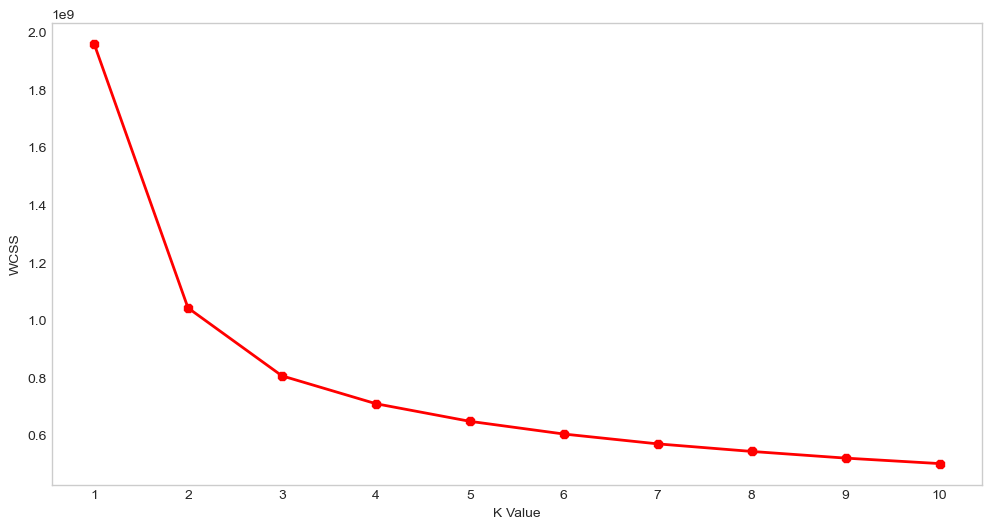

In [99]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(new_df_dep.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

The "elbow" shape is formed when the K-value is 3. The idea is that adding more clusters beyond this point does not significantly improve the quality of the clustering because the decreasing proportion of the sum of squares between points in the group is not as large as when using fewer clusters. This means we could achieve a good balance between capturing the variance among the groups and avoiding overfitting when there are 3 groups.

#### Clustering

In [100]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(new_df_dep)
new_df_dep["label"] = clusters

### 3) Evaluate the result

In [101]:
new_df_dep

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,label
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,...,0,0,0,0,1,0,0,5,22,0
2,0,0,2,9,3,0,1,48,21,0,...,3,1,0,0,11,1,0,36,42,0
3,0,0,0,3,0,0,0,21,2,4,...,0,0,0,0,4,0,0,38,9,0
4,2,0,2,3,0,0,1,0,2,0,...,0,0,0,0,0,0,0,2,1,0
5,0,0,0,0,0,0,1,8,1,1,...,2,0,0,0,2,0,0,19,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,1,2,1,0,0,0,14,3,0,...,0,1,1,0,0,0,0,7,0,0
206206,0,0,2,33,1,0,9,39,5,1,...,4,2,0,1,14,10,0,34,42,0
206207,0,1,3,20,4,0,11,52,8,8,...,1,6,0,0,15,0,0,50,23,0


As we have too many data points, I will just sample 10% of the data to visualize the clusters.

In [102]:
sample = new_df_dep.sample(n=20620)

In [103]:
sample.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,label
user_id,,,,,,,,,,,,,,,,,,,,,
45019,0,7,1,2,0,0,1,0,1,0,...,0,0,0,0,3,6,0,4,1,0
92266,0,0,0,4,3,0,0,19,0,0,...,0,0,0,0,0,0,0,9,3,0
43868,0,21,36,43,4,0,18,98,1,5,...,1,7,1,0,37,1,3,81,2,2
74985,0,0,15,13,3,0,4,4,3,0,...,0,0,0,0,5,1,0,15,12,0
68568,0,16,8,5,10,0,5,23,0,5,...,2,0,0,1,6,2,0,2,7,0


In [104]:
new_df_dep['label'].value_counts()

0    164470
2     34191
1      7548
Name: label, dtype: int64

There is a significant gap in the number of customers among the groups.

#### Calculate the silhouette score

To check how the clusters are well clustered, calculate the goodness of a clustering technique with silhouette coefficient. [-1, 1] 1 means clusters are well apart from each other and clearly distinguished. 

In [105]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

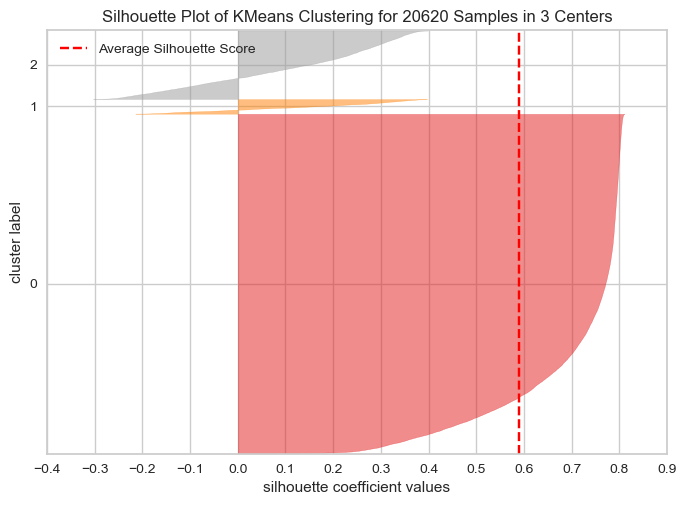

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 20620 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [106]:
dep_cluster = KMeans(n_clusters=3)
sil_visualizer = SilhouetteVisualizer(dep_cluster)
sil_visualizer.fit(sample.iloc[:, :-1])
sil_visualizer.show()

Upon analyzing the visualized silhouette score, a predominant observation emerges: a significant proportion of the data points cluster around label 0. The computed average silhouette score approximates 0.6. A silhouette score nearing +1 suggests robust alignment within a cluster and notable dissimilarity to neighboring clusters—a hallmark of a well-defined, distinct cluster. Conversely, a score around 0 indicates potential overlap between clusters, posing challenges in precise assignment due to comparable distances. While the current analysis remains meaningful, the elevated silhouette score prompts consideration of further customer segmentation analysis to refine clusters for enhanced accuracy.

### 4-2. Based on the number of orders each customer made at different times

### 1) Preparing the dataset

In [107]:
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department,aisle_id,department_id,eval_set,order_namber,days_since_prior_order
0,2539329,1,8,196.0,Soda,beverages,77.0,7.0,prior,1,0.0
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,91.0,16.0,prior,1,0.0
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,23.0,19.0,prior,1,0.0
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,23.0,19.0,prior,1,0.0
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,54.0,17.0,prior,1,0.0


In [108]:
# create a column based on order_hour_of_day
# define the conditions for different timings
conditions = [
    (df['order_hour_of_day'] >= 0) & (df['order_hour_of_day'] <= 7),
    (df['order_hour_of_day'] >= 8) & (df['order_hour_of_day'] <= 16),
    (df['order_hour_of_day'] >= 17) & (df['order_hour_of_day'] <= 23)
]

# define the corresponding values for each condition
values = ['Morning', 'Afternoon', 'Evening']

In [109]:
# create the new column 'timing_of_order'
df['timing_of_order'] = pd.Series(np.select(conditions, values, default='Unknown'))

In [110]:
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department,aisle_id,department_id,eval_set,order_namber,days_since_prior_order,timing_of_order
0,2539329,1,8,196.0,Soda,beverages,77.0,7.0,prior,1,0.0,Afternoon
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,91.0,16.0,prior,1,0.0,Afternoon
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,23.0,19.0,prior,1,0.0,Afternoon
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,23.0,19.0,prior,1,0.0,Afternoon
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,54.0,17.0,prior,1,0.0,Afternoon


In [111]:
# leave only needed columns
df_timing = df[['user_id','timing_of_order']]

In [112]:
df_timing.head()

,user_id,timing_of_order
0,1,Afternoon
1,1,Afternoon
2,1,Afternoon
3,1,Afternoon
4,1,Afternoon


In [113]:
# using crosstab to count the number of orders each customer made at different timings
new_df_timing = pd.crosstab(df_timing['user_id'], df_timing['timing_of_order'])

In [114]:
new_df_timing.head()

timing_of_order,Afternoon,Evening,Morning
user_id,,,
1,45,0,15
2,196,0,0
3,51,38,0
4,19,0,0
5,21,17,0


### 2) Applying K-Means algorithm

#### Using Elbow method to decide K value

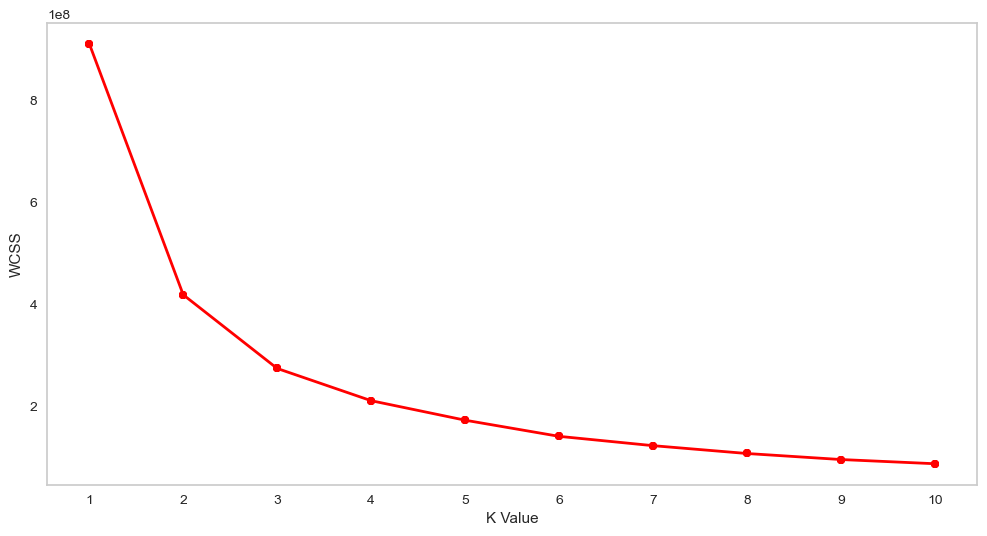

In [115]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(new_df_timing.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

The "elbow" shape is formed when the K-value is 4. The idea is that adding more clusters beyond this point does not significantly improve the quality of the clustering because the decreasing proportion of the sum of squares between points in the group is not as large as when using fewer clusters. This means we could achieve a good balance between capturing the variance among the groups and avoiding overfitting when there are 4 groups.

#### Clustering

In [116]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(new_df_timing)
new_df_timing["label"] = clusters

### 3) Evaluate the result

In [117]:
new_df_timing.head()

timing_of_order,Afternoon,Evening,Morning,label
user_id,,,,
1,45,0,15,2
2,196,0,0,0
3,51,38,0,2
4,19,0,0,2
5,21,17,0,2


In [118]:
new_df_timing['label'].value_counts()

2    146529
0     42585
1     13886
3      3209
Name: label, dtype: int64

### Visualize clustered groups

In [119]:
# Sample 10% of data
sample = new_df_timing.sample(n=20620)

In [120]:
sample['label'].value_counts()

2    14636
0     4233
1     1438
3      313
Name: label, dtype: int64

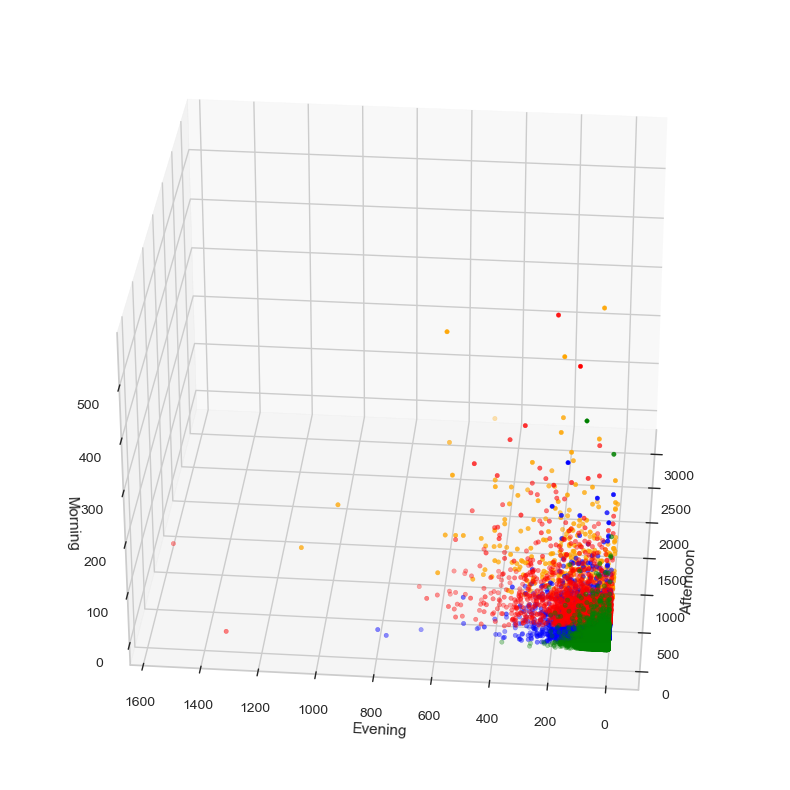

In [121]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['Afternoon'][sample.label == 0], sample['Evening'][sample.label == 0], sample['Morning'][sample.label == 0], c='blue', s=10)
ax.scatter(sample['Afternoon'][sample.label == 1], sample['Evening'][sample.label == 1], sample['Morning'][sample.label == 1], c='red', s=10)
ax.scatter(sample['Afternoon'][sample.label == 2], sample['Evening'][sample.label == 2], sample['Morning'][sample.label == 2], c='green', s=10)
ax.scatter(sample['Afternoon'][sample.label == 3], sample['Evening'][sample.label == 3], sample['Morning'][sample.label == 3], c='orange', s=10)
ax.view_init(30, 185)
plt.xlabel("Afternoon")
plt.ylabel("Evening")
ax.set_zlabel('Morning')
plt.show()

#### Calculate the silhouette score

To check how the clusters are well clustered, calculate the goodness of a clustering technique with silhouette coefficient. [-1, 1] 1 means clusters are well apart from each other and clearly distinguished. 

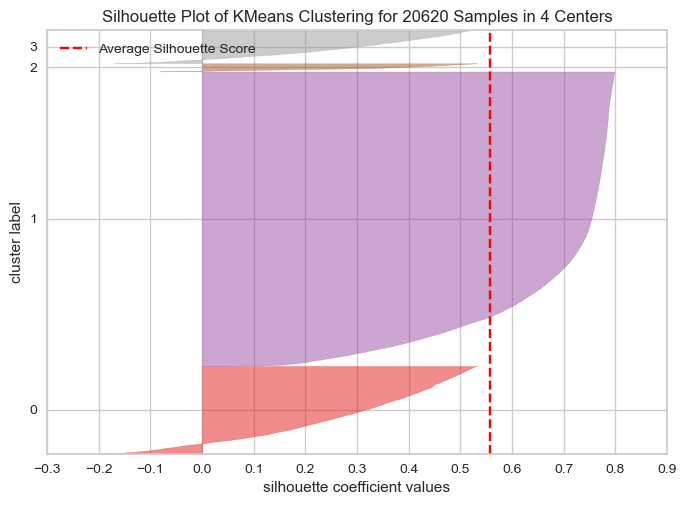

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 20620 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [122]:
km = KMeans(n_clusters=4)
sil_visualizer = SilhouetteVisualizer(km)
sil_visualizer.fit(sample[["Afternoon", "Evening", "Morning"]])
sil_visualizer.show()

The average silhouette score slightly exceeds 0.55. Although marginally smaller than the previous analysis, the current method maintains its significance. Each group demonstrates an average silhouette score that is closer to the overall average silhouette score compared to the previous method, further affirming the efficacy of this approach.

### 4-3. Based on the number of orders each customer made at different times, the number of days since the prior order amd the average number of products ordered per order

To achieve greater precision and granularity in grouping, additional features were incorporated to observe the impact on the segmentation score.

### 1) Preparing the dataset

In [123]:
df.head()

,order_id,user_id,order_hour_of_day,product_id,product_name,department,aisle_id,department_id,eval_set,order_namber,days_since_prior_order,timing_of_order
0,2539329,1,8,196.0,Soda,beverages,77.0,7.0,prior,1,0.0,Afternoon
1,2539329,1,8,14084.0,Organic Unsweetened Vanilla Almond Milk,dairy eggs,91.0,16.0,prior,1,0.0,Afternoon
2,2539329,1,8,12427.0,Original Beef Jerky,snacks,23.0,19.0,prior,1,0.0,Afternoon
3,2539329,1,8,26088.0,Aged White Cheddar Popcorn,snacks,23.0,19.0,prior,1,0.0,Afternoon
4,2539329,1,8,26405.0,XL Pick-A-Size Paper Towel Rolls,household,54.0,17.0,prior,1,0.0,Afternoon


In [124]:
# leave only needed columns
df_3 = df[['user_id','order_id','timing_of_order','days_since_prior_order']]

In [125]:
df_3.head()

,user_id,order_id,timing_of_order,days_since_prior_order
0,1,2539329,Afternoon,0.0
1,1,2539329,Afternoon,0.0
2,1,2539329,Afternoon,0.0
3,1,2539329,Afternoon,0.0
4,1,2539329,Afternoon,0.0


In [126]:
# create a new column 'num_product' that is showing the number of products with the same 'order_id'
df_3['num_product'] = df_3.groupby('order_id')['order_id'].transform('count')

In [127]:
# keep only one row per unique 'order_id'
df_3 = df_3.drop_duplicates(subset='order_id', keep='first')
df_3.head()

,user_id,order_id,timing_of_order,days_since_prior_order,num_product
0,1,2539329,Afternoon,0.0,5
5,1,2398795,Morning,15.0,6
11,1,473747,Afternoon,21.0,5
16,1,2254736,Morning,29.0,5
21,1,431534,Afternoon,28.0,8


In [128]:
# calculate an average days_since_prior_order and average num_product
df_3['avg_order_period'] = df_3.groupby('user_id')['days_since_prior_order'].transform('mean')
df_3['avg_num_product'] = df_3.groupby('user_id')['num_product'].transform('mean')
df_3.head()

,user_id,order_id,timing_of_order,days_since_prior_order,num_product,avg_order_period,avg_num_product
0,1,2539329,Afternoon,0.0,5,17.272727,5.454545
5,1,2398795,Morning,15.0,6,17.272727,5.454545
11,1,473747,Afternoon,21.0,5,17.272727,5.454545
16,1,2254736,Morning,29.0,5,17.272727,5.454545
21,1,431534,Afternoon,28.0,8,17.272727,5.454545


In [129]:
# seperate timing_of_order to count the number of orders at different timings
df_3_timing = pd.crosstab(df_3['user_id'], df_3['timing_of_order'])
df_3_timing

timing_of_order,Afternoon,Evening,Morning
user_id,,,
1,8,0,3
2,15,0,0
3,8,5,0
4,6,0,0
5,3,2,0
...,...,...,...
206205,4,0,0
206206,27,41,0
206207,11,3,3


In [130]:
# Attach avg_order_period and avg_num_product to df_3_timing
df_3 = df_3.drop_duplicates(subset='user_id', keep='first')
df_3.head()

,user_id,order_id,timing_of_order,days_since_prior_order,num_product,avg_order_period,avg_num_product
0,1,2539329,Afternoon,0.0,5,17.272727,5.454545
60,2,2168274,Afternoon,0.0,13,15.200000,13.066667
256,3,1374495,Afternoon,0.0,10,11.076923,6.846154
345,4,3343014,Afternoon,0.0,4,14.166667,3.166667
364,5,2717275,Afternoon,0.0,11,9.200000,7.600000


In [131]:
df_3 = df_3[['user_id','avg_order_period', 'avg_num_product']]

In [132]:
df_3.set_index('user_id', inplace=True)
df_3.head()

,avg_order_period,avg_num_product
user_id,,
1,17.272727,5.454545
2,15.200000,13.066667
3,11.076923,6.846154
4,14.166667,3.166667
5,9.200000,7.600000


In [133]:
df_3 = df_3.merge(df_3_timing, on="user_id")

In [134]:
df_3.head()

,avg_order_period,avg_num_product,Afternoon,Evening,Morning
user_id,,,,,
1,17.272727,5.454545,8,0,3
2,15.200000,13.066667,15,0,0
3,11.076923,6.846154,8,5,0
4,14.166667,3.166667,6,0,0
5,9.200000,7.600000,3,2,0


In [135]:
df_3.shape

(206209, 5)

### 2) Applying K-Means algorithm

#### Using Elbow method to decide K value

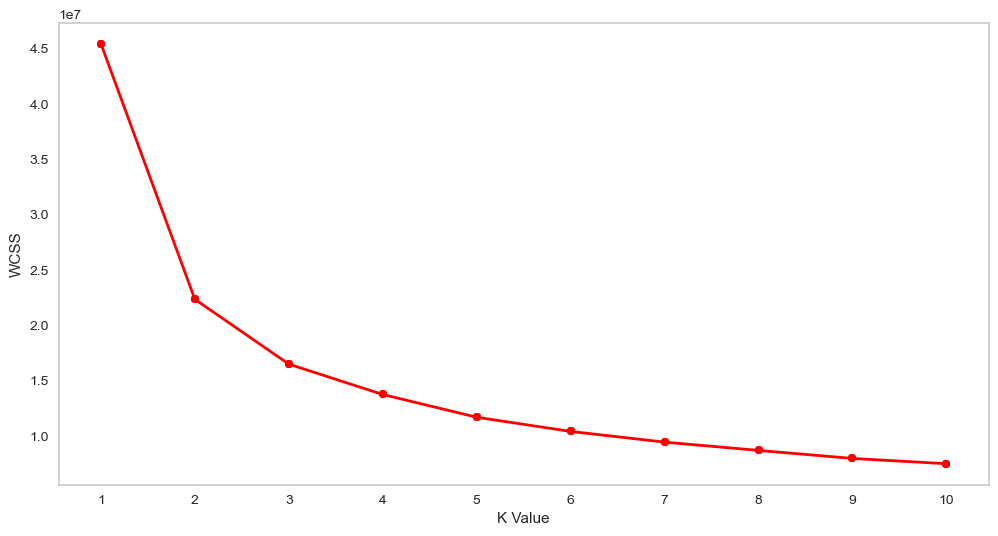

In [136]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_3.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

The "elbow" shape is formed when the K-value is 3. The idea is that adding more clusters beyond this point does not significantly improve the quality of the clustering because the decreasing proportion of the sum of squares between points in the group is not as large as when using fewer clusters. This means we could achieve a good balance between capturing the variance among the groups and avoiding overfitting when there are 3 groups.

#### Clustering

In [137]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(df_3)
df_3["label"] = clusters

### 3) Evaluate the result

In [138]:
df_3.head()

,avg_order_period,avg_num_product,Afternoon,Evening,Morning,label
user_id,,,,,,
1,17.272727,5.454545,8,0,3,1
2,15.200000,13.066667,15,0,0,1
3,11.076923,6.846154,8,5,0,1
4,14.166667,3.166667,6,0,0,1
5,9.200000,7.600000,3,2,0,1


In [139]:
df_3['label'].value_counts()

1    151567
0     43555
2     11087
Name: label, dtype: int64

#### Calculate the silhouette score

In [140]:
# Sample 10% of data
sample = df_3.sample(n=20620)

In [ ]:
km = KMeans(n_clusters=3)
sil_visualizer = SilhouetteVisualizer(km)
sil_visualizer.fit(sample.iloc[:, :-1])
sil_visualizer.show()

The average silhouette score is around 0.42, which is smaller than the scores obtained from the other two analysis methods. The notable decline in silhouette coefficient values across clusters suggests a lack of homogeneity within the cluster. This indicates that the cluster may not be internally cohesive, possibly harboring distinct subgroups or patterns. In comparison, the previous two clustering approaches demonstrate a superior ability to capture the underlying structure.

# summary

The project was divided into two different subjects: 1) Basket analysis and 2) Customer segmentation. 

In conducting the basket analysis, given the extensive dataset and varying order frequencies throughout the day, the data was segmented into three groups based on the hour of order placement. Utilizing the Apriori algorithm, nearly 400 item sets were derived, each exhibiting a support greater than 0.005 (0.5%) within its respective category. By isolating item sets surpassing a predefined threshold lift, several compelling combinations of items were unearthed, potentially indicating high interdependence. An illustrative example is the pairing of milk and vitamin D within these item sets.

Customer segmentation in marketing is crucial, enabling businesses to tailor campaigns and messages to specific customer groups, thereby increasing relevance and engagement. This targeted approach enhances the effectiveness of marketing efforts, leading to improved customer satisfaction and higher conversion rates. To achieve effective customer segmentation, three different approaches were tried in this project:

1. Based on the number of orders each customer made in each department.
2. Based on the number of orders each customer made at different times.
3. Based on the number of orders each customer made at different times, the number of days since the prior order, and the average number of products ordered per order.

Even though each approach was developed to enhance cluster precision from the previous approach, the first approach yielded the best results. This implies that the most favorable outcomes can be expected when conducting marketing campaigns based on the number of orders each customer made in each department. This approach effectively captured differences between the groups and clustered the customers into three groups quite homogeneously within the group.

This project has the potential for further development through the integration of Machine Learning for Predictive Segmentation. By developing models capable of anticipating shifts in customer behavior, the aim is to facilitate proactive adjustments in marketing strategies, ensuring the ability to stay ahead of evolving trends. These enhancements are designed to introduce a dynamic and adaptive dimension to the project, incorporating predictive capabilities to ensure the sustained effectiveness of the developed marketing strategies.